# Classe `JogoDeForca`: Implementação do Jogo
Nesta célula, implementamos a classe `JogoDeForca`, que simula o funcionamento do jogo de forca. A classe contém três métodos principais:

1. **`__init__`**: O construtor carrega o vocabulário permitido a partir da URL fornecida. Ele transforma o conteúdo da URL em uma lista de palavras, que será usada durante o jogo.

2. **`novo_jogo`**: Este método inicia uma nova partida. Ele seleciona aleatoriamente uma palavra do vocabulário e define o número de vidas para o jogador (por padrão, 5). Também inicializa o estado da palavra como uma lista de sublinhados (`_`) para indicar letras não descobertas.

3. **`tentar_letra`**: Neste método, o jogador pode tentar adivinhar uma letra. Se a letra estiver na palavra, o método retorna os índices onde a letra aparece e atualiza o `estado_palavra` com a letra revelada nesses índices. Caso contrário, o método diminui o número de vidas e retorna uma lista vazia. Esse mecanismo controla o progresso do jogo e as penalidades para letras incorretas.

4. **`tentar_palavra`**: Este método permite que o jogador tente adivinhar a palavra inteira. Se o palpite estiver correto, o método retorna `True`, indicando vitória. Caso contrário, o jogador perde todas as vidas, encerrando o jogo.

Essa estrutura define as regras e a lógica central do jogo, incluindo controle de vidas, revelação de letras corretas e detecção de vitórias e derrotas.


In [ ]:


import requests
import random
import numpy as np
from collections import Counter

class JogoDeForca:
    def __init__(self):
        url = 'https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt'
        r = requests.get(url, allow_redirects=True)
        if r.status_code == 200:
            self.content = str(r.content.decode()).split('\n')
        else:
            print("Erro:", r.status_code)

    def novo_jogo(self, vidas=5):
        self.vidas = vidas
        self.palavra = random.choice(self.content)
        self.estado_palavra = ["_"] * len(self.palavra)
        return len(self.palavra)

    def tentar_letra(self, letra):
        if self.vidas > 0:
            if letra in self.palavra:
                indices = [idx for idx, char in enumerate(self.palavra) if char == letra]
                for idx in indices:
                    self.estado_palavra[idx] = letra
                return indices
            else:
                self.vidas -= 1
                return []
        return False

    def tentar_palavra(self, palavra):
        if self.vidas > 0:
            if self.palavra == palavra:
                return True
            else:
                self.vidas = 0
                return False
            

# Classe `Jogador`: Implementação da Estratégia do Jogador de Forca
Nesta célula, implementamos a classe `Jogador`, que define a estratégia de seleção de letras baseada em entropia para maximizar as chances de sucesso no jogo de forca.

1. **`__init__`**: O construtor da classe recebe um vocabulário de palavras. Esse vocabulário é armazenado em um atributo, `self.vocabulario`, e será usado para verificar palavras compatíveis com o estado atual da palavra no jogo.

2. **`calcular_entropia`**: Este método calcula a entropia das letras nas palavras compatíveis, excluindo as letras já tentadas. A entropia é uma medida de incerteza e é calculada usando a frequência de cada letra nas palavras compatíveis. O cálculo é feito da seguinte forma:
   - Primeiro, conta-se a frequência de cada letra em `palavras`, que são as palavras que ainda podem ser a palavra secreta.
   - Em seguida, o total de letras é calculado.
   - A entropia de cada letra é dada por: \(- (P(letra) \times \log_2(P(letra)))\), onde \(P(letra)\) é a probabilidade de uma letra aparecer nas palavras compatíveis. Este valor é acumulado em um dicionário `entropias` para as letras que ainda não foram tentadas.

3. **`escolher_letra`**: Este método usa o estado atual da palavra (`estado_palavra`) e as letras já tentadas (`letras_tentadas`) para selecionar a próxima letra.
   - Primeiro, ele filtra as palavras do vocabulário para encontrar aquelas compatíveis com o estado atual da palavra (isto é, com o mesmo comprimento e com letras descobertas nas mesmas posições).
   - Depois, ele chama `calcular_entropia` para obter as entropias das letras nas palavras compatíveis.
   - A letra com a maior entropia é escolhida como a próxima tentativa, pois ela representa a maior incerteza e potencial de redução do espaço de busca. Se não houver letras válidas, retorna `None`.

Essa abordagem utiliza o conceito de entropia para escolher letras que maximizem a informação ganha a cada tentativa, aumentando as chances de sucesso do jogador.


In [ ]:

class Jogador:
    def __init__(self, vocabulario):
        self.vocabulario = vocabulario

    def calcular_entropia(self, palavras, letras_tentadas):
        contagem_letras = Counter("".join(palavras))
        total_letras = sum(contagem_letras.values())
        
        entropias = {letra: - (contagem_letras[letra] / total_letras) * np.log2(contagem_letras[letra] / total_letras) 
                     for letra in contagem_letras if letra not in letras_tentadas}
        return entropias

    def escolher_letra(self, estado_palavra, letras_tentadas):
        palavras_compatíveis = [palavra for palavra in self.vocabulario if len(palavra) == len(estado_palavra)]
        palavras_compatíveis = [p for p in palavras_compatíveis if all(
            estado_palavra[i] == "_" or estado_palavra[i] == p[i] for i in range(len(estado_palavra)))]

        entropias = self.calcular_entropia(palavras_compatíveis, letras_tentadas)
        if entropias:
            return max(entropias, key=entropias.get)
        return None


# Função `simular_jogos`: Simulação do Jogo de Forca com o Jogador Automático

Nesta célula, implementamos a função `simular_jogos`, que simula múltiplos jogos de forca para avaliar o desempenho do jogador automático.

1. **Parâmetros**:
   - `jogador`: uma instância da classe `Jogador`, que contém a lógica para selecionar as letras durante o jogo.
   - `num_jogos`: o número de jogos a serem simulados, com valor padrão de 100.

2. **Processo de Simulação**:
   - **Início do Jogo**: A função começa criando uma nova instância da classe `JogoDeForca`, que gerencia o jogo de forca. Para cada jogo, a palavra secreta é escolhida aleatoriamente do vocabulário e o estado da palavra começa com todos os caracteres sendo sublinhados ("_").
   - **Jogando**: Dentro de um loop que continua enquanto o jogador tiver vidas e a palavra não estiver completamente adivinhada, o jogador escolhe uma letra (usando o método `escolher_letra` da classe `Jogador`). A letra é então tentada no jogo. Se a letra estiver correta, o estado da palavra é atualizado, e caso contrário, o número de vidas do jogador é reduzido.
   - **Condição de Vitória ou Derrota**: Se o jogador adivinhar a palavra corretamente (não houver mais sublinhados), ele vence o jogo. Caso contrário, o jogo termina quando as vidas se esgotam.
   
3. **Resultados**:
   - Ao final de cada jogo, o status (vitória ou derrota) é impresso, junto com a palavra secreta e o número de vidas restantes.
   - A função acumula os resultados das vitórias e calcula a taxa de vitórias ao final da simulação. A taxa de vitória é calculada como o número de vitórias dividido pelo número total de jogos simulados, e é exibida em formato percentual.

4. **Execução da Simulação**:
   - A função é chamada com o jogador instanciado e o número de jogos definido. No exemplo, estamos simulando 100 jogos, mas o número pode ser alterado conforme necessário.

Esta célula permite avaliar o desempenho do jogador automático, fornecendo a taxa de vitória após simular uma série de jogos. O desempenho do jogador é um reflexo da estratégia de seleção de letras baseada em entropia.


In [ ]:

def simular_jogos(jogador, num_jogos=100):
    resultados = []
    jogo = JogoDeForca()
    
    for i in range(1, num_jogos + 1):
        num_letras = jogo.novo_jogo()
        letras_tentadas = set()
        venceu = False
        
        while jogo.vidas > 0 and "_" in jogo.estado_palavra:
            letra = jogador.escolher_letra(jogo.estado_palavra, letras_tentadas)
            if letra is None:
                break
            letras_tentadas.add(letra)
            jogo.tentar_letra(letra)
                
            if "_" not in jogo.estado_palavra:
                venceu = True
                break

        resultados.append(venceu)
        status = "Vitória" if venceu else "Derrota"
        print(f"Jogo {i}: {status}")
        print(f"Palavra: {jogo.palavra}")
        print(f"Vidas restantes: {jogo.vidas}\n{'-'*30}")

    total_vitorias = sum(resultados)
    print(f"\nTotal de jogos: {num_jogos}")
    print(f"Total de vitórias: {total_vitorias}")
    print(f"Taxa de vitória: {total_vitorias / num_jogos * 100:.2f}%")

# Inicialização do jogador e simulação
jogo = JogoDeForca()
jogador = Jogador(jogo.content)
simular_jogos(jogador, num_jogos=100)


Jogo 1: Vitória
Palavra: apimentares
Vidas restantes: 4
------------------------------
Jogo 2: Vitória
Palavra: abiscoitaste
Vidas restantes: 4
------------------------------
Jogo 3: Derrota
Palavra: bicais
Vidas restantes: 0
------------------------------
Jogo 4: Vitória
Palavra: penitenciei
Vidas restantes: 1
------------------------------
Jogo 5: Vitória
Palavra: olvidaras
Vidas restantes: 2
------------------------------
Jogo 6: Vitória
Palavra: embocai
Vidas restantes: 2
------------------------------
Jogo 7: Vitória
Palavra: despertador
Vidas restantes: 5
------------------------------
Jogo 8: Vitória
Palavra: equilibrasses
Vidas restantes: 4
------------------------------
Jogo 9: Vitória
Palavra: engatilharias
Vidas restantes: 3
------------------------------
Jogo 10: Vitória
Palavra: avermelhamos
Vidas restantes: 5
------------------------------

Total de jogos: 10
Total de vitórias: 9
Taxa de vitória: 90.00%


Resultado 

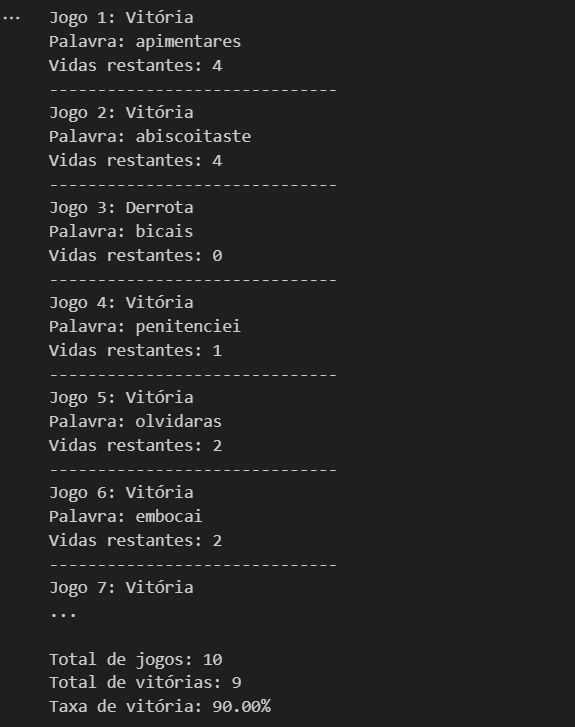